## Overview

This notebook demonstrates 3 different approaches to generating essays using the [Gemini API in Google AI Studio](https://ai.google.dev/gemini-api/docs). Each method illustrates a distinct paradigm for running AI Agents in differing levels of complexity.

1. Zero-Shot Approach with the Gemini API
2. Step-by-Step Approach With LangChain
3. Iterative, AI-Agent Approach with LangGraph

## Get started

### Install Gemini SDK and other required packages


In [1]:
# !pip install tavily-python

In [2]:
# !pip install -U ipywidgets

In [3]:
# %pip install --upgrade --user --quiet \
#     google-generativeai \
#     langgraph \
#     langchain \
#     langchain-google-genai \
#     # langchain-google-vertexai \
#     langchain-community \
#     tavily-python \
#     pydantic

### Configure API keys

Get API keys from [Google AI Studio](https://ai.google.dev/gemini-api/docs/api-key) and [Tavily](https://tavily.com/).

In [4]:
import os
import dotenv

dotenv.load_dotenv()    

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

## LangGraph를 사용한 반복적인 AI 에이전트 방식으로 에세이 생성하기

대규모 언어 모델을 사용하여 에세이를 생성, 수정 및 비평하는 angGraph](https://langchain-ai.github.io/langgraph/) 기반 AI 에이전트를 구축하는 방법을 보여줍니다. 

"Planner", "Research Plan", "Generate", "Reflect" 및 "Research Critique"와 같은 노드를 사용하여 구조화된 상태 흐름을 정의함으로써 시스템은 주어진 주제에 대한 에세이를 반복적으로 생성하고, 피드백을 통합하고, 연구 기반 통찰력을 제공합니다.

<img src="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/workshops/ai-agents/3-langgraph-essay.png?raw=1" width="900px">

이 워크플로는 수정 제어를 통해 자동화된 에세이 생성을 가능하게 하므로 구조화된 작문 작업이나 교육용 사용 사례에 적합합니다. 또한 이 노트북은 외부 검색 도구를 사용하여 실시간 정보를 수집하고 에세이 콘텐츠에 통합합니다.

### Import libraries

In [5]:
from typing import TypedDict

# Common libraries
from IPython.display import Image, Markdown, display

# LangChain and LangGraph components
from langchain_core.messages import HumanMessage, SystemMessage

# LangChain integrations for Gemini API in Google AI Studio and Vertex AI
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph

# Typing utilities for data validation and schema definitions
from pydantic.v1 import BaseModel

# Tavily client for performing web searches
from tavily import TavilyClient

### 에이전트 메모리, 에이전트 상태 및 검색 쿼리 스키마 초기화

In [15]:
# Initialize agent memory
memory = MemorySaver()


# Define the agent's state
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: list[str]
    revision_number: int
    max_revisions: int


# Define a schema for search queries
class Queries(BaseModel):
    """Variants of query to search for"""

    queries: list[str]

### Gemini 모델 및 검색 도구 초기화

환경 변수 `GOOGLE_API_KEY` 및 `TAVILY_API_KEY`를 설정해야 합니다. Vertex AI로 전환하는 경우 Vertex AI에 대한 자격 증명을 구성하십시오.

In [16]:
# Initialize Gemini API in Google AI Studio via LangChain
model = ChatGoogleGenerativeAI(model="gemini-1.5-pro", temperature=0)

# Initialize Gemini API in Vertex AI via LangChain
# model = ChatVertexAI(model="gemini-1.5-pro-002", temperature=0)

# Initialize Tavily client for performing web searches
tavily = TavilyClient()

### 각 단계를 위한 프롬프트 템플릿 정의

In [17]:
PLAN_PROMPT = """당신은 에세이의 개요를 작성하는 전문가입니다.
        1. {topic}에 대한 최신 트렌드(latest trends), 주요 업체(key players) 및 주목할 만한 뉴스(noteworthy news)를 우선적으로 고려합니다.\n
        2. 대상 독자(target audience)의 관심사(interests)와 고충(pain points)을 고려하여 파악합니다.\n
        3. 서론(introduction), 핵심 내용(key points), 행동 촉구(call to action)를 포함한 상세한 콘텐츠 개요(content outline)를 작성합니다.\n
        4. SEO 키워드(SEO keywords)와 관련된 데이터(data) 또는 소스(sources)를 포함합니다.

"""

WRITER_PROMPT = """당신은 훌륭한 3단락 에세이를 작성하는 에세이 도우미 (essay assistant) 입니다.
        1. 콘텐츠 계획(content plan)을 활용하여 {topic}에 대한 설득력 있는 블로그 게시물(blog post)을 작성합니다.\n
        2. SEO 키워드(SEO keywords)를 자연스럽게 통합합니다.\n
        3. 섹션/소제목(Sections/Subtitles)이 매력적인 방식으로 적절하게 명명되었는지 확인합니다.\n
        4. 게시물이 매력적인 서론(introduction), 통찰력 있는 본문(insightful body) 및 요약 결론(summarizing conclusion)으로 구성되었는지 확인합니다.\n
        5. 문법적 오류(grammatical errors)가 없는지, 브랜드의 목소리(brand's voice)와 일치하는지 교정합니다(Proofread).\n
        
        expected_output : 잘 작성된 블로그 게시물(blog post)을 마크다운 형식(markdown format)으로 제공하며, 각 섹션은 2~3개의 단락(paragraphs)으로 구성되어 출판 준비가 완료되어야 합니다.
"""

REFLECTION_PROMPT = "주어진 블로그 게시물(blog post)에서 문법적 오류(grammatical errors)를 교정하고 브랜드의 목소리(brand's voice)와 일치하는지 확인합니다."

RESEARCH_PLAN_PROMPT = """당신은 다음 에세이를 작성하는 데 사용할 수 있는 정보를 제공하는 연구원 (researcher) 입니다.
관련 정보를 수집할 검색어 목록을 생성하십시오. 최대 3개의 쿼리 (queries) 만 생성하십시오."""

RESEARCH_CRITIQUE_PROMPT = """당신은 요청된 수정 사항 (아래에 설명됨) 을 작성하는 데 사용할 수 있는 정보를 제공하는 연구원 (researcher) 입니다.
관련 정보를 수집할 검색어 목록을 생성하십시오. 최대 3개의 쿼리 (queries) 만 생성하십시오."""

### 각 단계를 위한 노드 함수 정의

In [18]:
# Generate an outline for the essay


def plan_node(state: AgentState):
    # messages = [SystemMessage(content=PLAN_PROMPT), HumanMessage(content=state["task"])]
    # response = model.invoke(messages)
    content = "\n\n".join(state["content"] or [])
    user_message = HumanMessage(content=state["task"])
    messages = [
        SystemMessage(content=PLAN_PROMPT.format(topic=content)),
        user_message,
    ]    
    response = model.invoke(messages)
    return {"plan": response.content}


# Conducts research based on the generated plan and web search results
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke(
        [
            SystemMessage(content=RESEARCH_PLAN_PROMPT),
            HumanMessage(content=state["task"]),
        ]
    )
    content = state["content"] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}


# Generates a draft based on the content and plan
def generation_node(state: AgentState):
    content = "\n\n".join(state["content"] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}"
    )
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(topic=content)),
        user_message,
    ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1,
    }


# Provides feedback or critique on the draft
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state["draft"]),
    ]
    response = model.invoke(messages)
    return {"critique": response.content}


# Conducts research based on the critique
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke(
        [
            SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
            HumanMessage(content=state["critique"]),
        ]
    )
    content = state["content"] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}


# Determines whether the critique and research cycle should
# continue based on the number of revisions
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

### 그래프 정의 및 컴파일

In [19]:
# Initialize the state graph
builder = StateGraph(AgentState)

# Add nodes for each step in the workflow
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

# Set the entry point of the workflow
builder.set_entry_point("planner")

# Add conditional edges for task continuation or end
builder.add_conditional_edges(
    "generate", should_continue, {END: END, "reflect": "reflect"}
)

# Define task sequence edges
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

# Compile the graph with memory state management
graph = builder.compile(checkpointer=memory)

### 컴파일된 그래프 보기

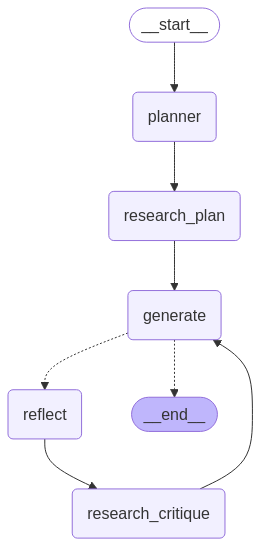

In [20]:
Image(graph.get_graph().draw_mermaid_png())

### 에이전트 실행 - 글쓰기 시작!

In [21]:
# Define the topic of the essay
TOPIC = "인공지능"

# Define a thread configuration with a unique thread ID
thread = {"configurable": {"thread_id": "1"}}

# Stream through the graph execution with an initial task and state
for s in graph.stream(
    {
        "task": TOPIC,  # Initial task
        "max_revisions": 2,  # Maximum number of revisions allowed
        "revision_number": 1,  # Current revision number
        "content": [],  # Initial empty content list
    },
    thread,
):
    step = next(iter(s))
    display(Markdown(f"# {step}"))
    for key, content in s[step].items():
        if key == "revision_number":
            display(Markdown(f"**Revision Number**: {content}"))
        elif isinstance(content, list):
            for c in content:
                display(Markdown(c))
        else:
            display(Markdown(content))
    print("\n---\n")

### 에세이 최종본 출력

In [14]:
display(Markdown(s["generate"]["draft"]))

## The Devastating Duo: Hurricanes Helene and Milton in 2024

The 2024 Atlantic hurricane season will be infamously remembered for the one-two punch of Hurricanes Helene and Milton.  These powerful storms, striking within weeks of each other, left an indelible mark on the Southeastern United States, causing widespread destruction and economic losses exceeding hundreds of billions of dollars.  While both contributed to the season's devastating toll, their distinct characteristics, paths, and impacts underscore the complex challenges posed by hurricane preparedness and response.

## Meteorological Overview

Hurricane Helene, making landfall on September 26, 2024, as a Category 4 storm, unleashed its fury primarily on Florida's Big Bend region.  The storm boasted wind gusts exceeding 90 mph in some areas and brought torrential rainfall, leading to widespread flooding.  Two weeks later, Hurricane Milton, a Category 3 storm, slammed into Florida's west coast on October 9, 2024.  While slightly weaker than Helene in terms of wind speed, Milton's impact was exacerbated by its unusual track and the already saturated ground from Helene's deluge.  Milton also spawned several tornadoes, adding another layer of complexity to the disaster.  The close succession of these storms presented unprecedented challenges for recovery efforts.

## Impacts and Aftermath

Helene's impact was catastrophic, resulting in over 230 fatalities and estimated economic losses between $225 and $250 billion.  The storm caused extensive damage to infrastructure, including wastewater treatment facilities, leading to the release of millions of gallons of untreated wastewater.  Coastal communities bore the brunt of the storm surge and high winds, while inland areas grappled with severe flooding and landslides.  Milton, while less deadly, further compounded the damage, impacting many of the same communities still reeling from Helene.  The storm's economic toll reached an estimated $25 billion, adding to the already staggering financial burden.  The combined effects of Helene and Milton placed immense strain on resources, hindering recovery efforts and leaving lasting environmental scars, including coastal erosion and ecosystem damage.  The 2024 hurricane season served as a stark reminder of the destructive power of nature and the critical need for effective preparedness and response strategies in the face of increasingly frequent and intense weather events.